In [ ]:
! pip install matplotlib seaborn pandas numpy
! pip install spicy 

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [2]:
def convert_csv_to_dataframe(path):
    df = pd.read_csv(path, encoding = 'utf-16')
    return df

In [3]:
def extract_questionnaire(start_ID, data, values, variables):
    questionnaire_data = data.filter(regex=f'^{start_ID}')
    questionnaire_values = values[values['VAR'].str.startswith(start_ID)]
    questionnaire_variables = variables[variables['VAR'].str.startswith(start_ID)]

    questionnaire_data_long = questionnaire_data.melt(var_name='VAR', value_name='RESPONSE')
    df_merged = questionnaire_data_long.merge(questionnaire_variables, how='left', on='VAR')
    df_merged = df_merged[['VAR', 'LABEL', 'RESPONSE']]

    df_pivoted = df_merged.pivot_table(index=['VAR', 'LABEL'], 
                            columns=df_merged.groupby(['VAR', 'LABEL']).cumcount() + 1, 
                            values='RESPONSE',  aggfunc=lambda x: x.tolist()).reset_index()
    df_pivoted.columns = ['VAR', 'LABEL'] + [f'RESPONSE_{i}' for i in range(1, 7)]

    return df_pivoted

### **Pre study Questionnaire**

In [4]:
data = convert_csv_to_dataframe('csv/data.csv')
values = convert_csv_to_dataframe('csv/values.csv')
variables = convert_csv_to_dataframe('csv/variables.csv')

In [5]:
prestudy_questionnaire = extract_questionnaire("PS", data=data, values=values, variables=variables)
prestudy_questionnaire.head(10)

,VAR,LABEL,RESPONSE_1,RESPONSE_2,RESPONSE_3,RESPONSE_4,RESPONSE_5,RESPONSE_6
0,PS01,Receiving Notifications,[Very helpful [5]],[Mostly distracted [2]],[Neutral [3]],[Mostly helpful [4]],[Mostly helpful [4]],[Neutral [3]]
1,PS02_01,Situation of receiving notifications: [01],[messages notification is the most useful for me],[alarm clock],[nan],[Benachrichtigunen von Nachrichten-Apps (Beisp...,[Notifications about pending minor Software Up...,[system notification]
2,PS04_01,Notification management: I turn off notificati...,[5],[5],[4],[5],[2],[7]
3,PS04_02,Notification management: I customize notificat...,[7],[5],[2],[2],[7],[6]
4,PS04_03,"Notification management: I use ""Do Not Disturb...",[6],[7],[7],[7],[1],[6]
5,PS04_04,Notification management: I manage notification...,[5],[2],[4],[5],[2],[6]
6,PS04_05,Notification management: I manually check and ...,[5],[6],[1],[2],[7],[5]
7,PS04_06,Notification management: I don’t manage notifi...,[4],[4],[4],[6],[2],[1]
8,PS06_01,Handling Notifications: I turn off notificati...,[5],[7],[7],[7],[7],[7]
9,PS06_02,Handling Notifications: I set specific times ...,[1],[1],[1],[1],[2],[6]


### **Noti Interactions**


In [6]:
interaction_df = pd.read_csv('csv_noti/notifications.csv')
interaction_df

,_id,user_id,notification_id,variant,notificationShownAt,position,isInterested,createdAt,updatedAt,__v
0,66d6edb47e1c59901abecb67,1,notification1,info,2024-09-03 11:06:28.831,"{'vertical': 'bottom', 'horizontal': 'left'}",False,2024-09-03 11:06:28.836,2024-09-03 11:06:28.836,0
1,66d6ede27e1c59901abecb69,1,notification2,reportComplete,2024-09-03 11:07:14.757,"{'vertical': 'bottom', 'horizontal': 'center'}",False,2024-09-03 11:07:14.758,2024-09-03 11:07:14.758,0
2,66d6ee187e1c59901abecb6b,1,notification3,info,2024-09-03 11:08:08.652,"{'vertical': 'bottom', 'horizontal': 'right'}",True,2024-09-03 11:08:08.655,2024-09-03 11:08:08.655,0
3,66d6ee427e1c59901abecb6d,1,notification4,reportComplete,2024-09-03 11:08:50.418,"{'vertical': 'bottom', 'horizontal': 'left'}",True,2024-09-03 11:08:50.418,2024-09-03 11:08:50.418,0
4,66d6ee5f7e1c59901abecb6f,1,notification5,info,2024-09-03 11:09:19.346,"{'vertical': 'bottom', 'horizontal': 'center'}",True,2024-09-03 11:09:19.350,2024-09-03 11:09:19.350,0
5,66d6ee7e7e1c59901abecb71,1,notification6,reportComplete,2024-09-03 11:09:50.521,"{'vertical': 'bottom', 'horizontal': 'right'}",False,2024-09-03 11:09:50.522,2024-09-03 11:09:50.522,0
6,66d6f6e4c12a568aa119ed1b,2,notification3,info,2024-09-03 11:45:40.573,"{'vertical': 'bottom', 'horizontal': 'right'}",True,2024-09-03 11:45:40.576,2024-09-03 11:45:40.576,0
7,66d6f712c12a568aa119ed1d,2,notification4,reportComplete,2024-09-03 11:46:26.643,"{'vertical': 'bottom', 'horizontal': 'left'}",False,2024-09-03 11:46:26.643,2024-09-03 11:46:26.643,0
8,66d6f757c12a568aa119ed1f,2,notification5,info,2024-09-03 11:47:35.106,"{'vertical': 'bottom', 'horizontal': 'center'}",False,2024-09-03 11:47:35.107,2024-09-03 11:47:35.107,0
9,66d6f774c12a568aa119ed21,2,notification6,reportComplete,2024-09-03 11:48:04.778,"{'vertical': 'bottom', 'horizontal': 'right'}",True,2024-09-03 11:48:04.783,2024-09-03 11:48:04.783,0


In [7]:
import ast

def parse_position_string(pos_str):
    try:
        # Convert the string representation to a dictionary
        pos_dict = ast.literal_eval(pos_str)
        # Extract the values
        vertical = pos_dict.get('vertical', 'unknown')
        horizontal = pos_dict.get('horizontal', 'unknown')
        # Return the formatted string
        return f"{vertical} - {horizontal}"
    except (ValueError, SyntaxError):
        # Handle cases where the string is not a valid dictionary
        return 'unknown'


In [8]:
def format_columns(df):
    df['variant'] = df['variant'].replace({'reportComplete': 'expandableNoti', 'info': 'simpleNoti'})

    df['notificationShownAt'] = pd.to_datetime(df['notificationShownAt'])
    df['createdAt'] = pd.to_datetime(df['createdAt'])
    df['duration'] = df['createdAt'] - df['notificationShownAt']
    df['formatted_duration'] = df['duration'].dt.total_seconds()
    
    df['formatted_position'] = df['position'].apply(parse_position_string)
   
    df = df[['notification_id','variant','formatted_position','isInterested','formatted_duration']]

    return df

In [9]:
interaction_df = format_columns(interaction_df)
interaction_df

,notification_id,variant,formatted_position,isInterested,formatted_duration
0,notification1,simpleNoti,bottom - left,False,0.005
1,notification2,expandableNoti,bottom - center,False,0.001
2,notification3,simpleNoti,bottom - right,True,0.003
3,notification4,expandableNoti,bottom - left,True,0.000
4,notification5,simpleNoti,bottom - center,True,0.004
5,notification6,expandableNoti,bottom - right,False,0.001
6,notification3,simpleNoti,bottom - right,True,0.003
7,notification4,expandableNoti,bottom - left,False,0.000
8,notification5,simpleNoti,bottom - center,False,0.001
9,notification6,expandableNoti,bottom - right,True,0.005


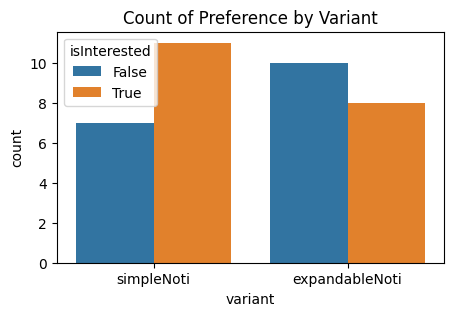

In [10]:
plt.figure(figsize=(5,3))
sns.countplot(data=interaction_df, x='variant', hue='isInterested')
plt.title('Count of Preference by Variant')
plt.show()


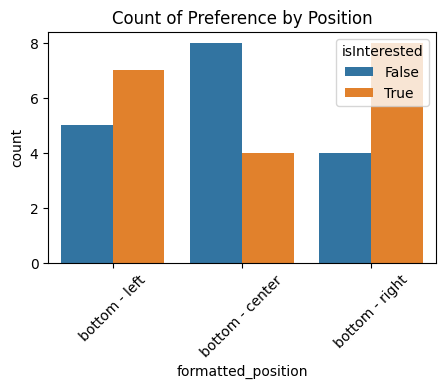

In [11]:
plt.figure(figsize=(5,3))
sns.countplot(data=interaction_df, x='formatted_position', hue='isInterested')
plt.title('Count of Preference by Position')
plt.xticks(rotation=45)
plt.show()

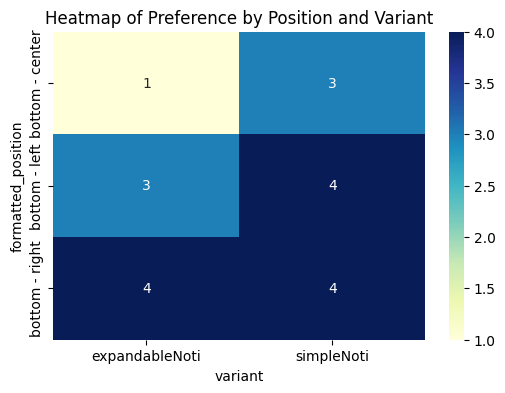

In [12]:
pivot_df = interaction_df.pivot_table(index='formatted_position', columns='variant', values='isInterested', aggfunc='sum', fill_value=0)
plt.figure(figsize=(6,4))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Preference by Position and Variant')
plt.show()

In [13]:
# Create a contingency table for variant and isInterested
contingency_table_variant = pd.crosstab(interaction_df["variant"], interaction_df["isInterested"])

# Perform chi-square test for variant and isInterested
chi2_variant, p_variant, dof_variant, ex_variant = chi2_contingency(contingency_table_variant)

# Create a contingency table for formatted_position and isInterested
contingency_table_position = pd.crosstab(interaction_df["formatted_position"], interaction_df["isInterested"])

# Perform chi-square test for formatted_position and isInterested
chi2_position, p_position, dof_position, ex_position = chi2_contingency(contingency_table_position)

# Print the results
print("Chi-square test for variant and isInterested:")
print(f"Chi2: {chi2_variant}, p-value: {p_variant}, Degrees of Freedom: {dof_variant}")
alpha = 0.05  # significance level
if p_position < alpha:
    print("\nThere is a significant association between the variables (p < 0.05).")
else:
    print("\nThere is no significant association between the variables (p >= 0.05).")

print("\nChi-square test for formatted_position and isInterested:")
print(f"Chi2: {chi2_position}, p-value: {p_position}, Degrees of Freedom: {dof_position}")
alpha = 0.05  # significance level
if p_variant < alpha:
    print("\nThere is a significant association between the variables (p < 0.05).")
else:
    print("\nThere is no significant association between the variables (p >= 0.05).")

Chi-square test for variant and isInterested:
Chi2: 0.4458204334365325, p-value: 0.5043264757421704, Degrees of Freedom: 1

There is no significant association between the variables (p >= 0.05).

Chi-square test for formatted_position and isInterested:
Chi2: 2.897832817337461, p-value: 0.23482460418702233, Degrees of Freedom: 2

There is no significant association between the variables (p >= 0.05).


### **Post study Questionnaire: UEQ**

In [14]:
user_experience_questionnaire = extract_questionnaire("UE", data=data, values=values, variables=variables)
user_experience_questionnaire.head(10)

,VAR,LABEL,RESPONSE_1,RESPONSE_2,RESPONSE_3,RESPONSE_4,RESPONSE_5,RESPONSE_6
0,UE01_01,UEQ Noti Type 1: annoying/enjoyable,[4],[3],[4],[4],[4],[1]
1,UE01_02,UEQ Noti Type 1: not understandable/understand...,[6],[7],[6],[5],[2],[4]
2,UE01_03,UEQ Noti Type 1: creative/dull,[4],[5],[5],[7],[6],[6]
3,UE01_04,UEQ Noti Type 1: easy to learn/difficult to learn,[2],[1],[1],[1],[2],[6]
4,UE01_05,UEQ Noti Type 1: valuable/inferior,[2],[4],[3],[5],[4],[6]
5,UE01_06,UEQ Noti Type 1: boring/exciting,[4],[3],[4],[1],[2],[2]
6,UE01_07,UEQ Noti Type 1: not interesting/interesting,[4],[2],[5],[2],[2],[1]
7,UE01_08,UEQ Noti Type 1: unpredictable/predictable,[3],[6],[3],[7],[3],[4]
8,UE01_09,UEQ Noti Type 1: fast/slow,[4],[2],[1],[4],[2],[4]
9,UE01_10,UEQ Noti Type 1: inventive/conventional,[4],[3],[4],[7],[6],[6]


In [15]:
def save_UEQ_results(df):
    for col in [f'RESPONSE_{i}' for i in range(1, 7)]:
      df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) else x)

    df_long = pd.melt(df, id_vars=['VAR'], var_name='Response_Type', value_name='Response_Value')
    df_pivot = df_long.pivot(index='Response_Type', columns='VAR', values='Response_Value')
    df_pivot = df_pivot.reset_index()

    df_pivot.to_csv('UEQ_data.csv', index=False)

In [16]:
save_UEQ_results(user_experience_questionnaire)

### **Demographic Questionnaire: UEQ**

In [17]:
demographic_questionnaire = extract_questionnaire('DQ', data=data, values=values, variables=variables)
demographic_questionnaire

,VAR,LABEL,RESPONSE_1,RESPONSE_2,RESPONSE_3,RESPONSE_4,RESPONSE_5,RESPONSE_6
0,DQ01,Gender,[Female],[Female],[Female],[Male],[Male],[Female]
1,DQ02_01,Age: [01],[25],[22],[21],[21],[23],[23]
2,DQ03,Qualification,[Partial university education or university of...,[Higher education entrance qualification (Abit...,[Partial university education or university of...,[Higher education entrance qualification (Abit...,[Higher education entrance qualification (Abit...,[Partial university education or university of...
3,DQ04_01,Work: [01],[Student],[student],[Student],[Student],[Student],[student]
4,DQ05_01,Matr-nr: [01],[No],[nan],[nan],[Sebastian Simbeck 2281438],[Felix Lindner 2307901],[no]
